# Lab 6: Translate with transformers
### Authors
- Francisco Roh
- Bryan Calisto


Read the paper:

https://papers.nips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf

Implement a English-Spanish translator using transformers, use this tutorial for help:

https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial6/Transformers_and_MHAttention.html

Use the attention model from class to compare a few translations.

In [8]:
## Standard libraries
import os
import numpy as np
import random
import math
import json
from functools import partial

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

## tqdm for loading bars
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

## Torchvision
import torchvision
from torchvision.datasets import CIFAR100
from torchvision import transforms

# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

<ipython-input-8-c8fdf9d3ded7>:14: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
INFO:lightning_fabric.utilities.seed:Seed set to 42


Device: cuda:0


<Figure size 640x480 with 0 Axes>

### Preprocesamiento con las funciones proporcionadas

In [99]:
import torch
import re
import unicodedata
from torch.utils.data import DataLoader, TensorDataset, RandomSampler
import numpy as np

SOS_token = 0
EOS_token = 1
MAX_LENGTH = 10

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s.strip()

def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long).unsqueeze(0)

def tensorsFromPair(pair, input_lang, output_lang):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)


def filterPair(p):
    try:
        return len(p[0].split(' ')) < MAX_LENGTH and \
            len(p[1].split(' ')) < MAX_LENGTH
    except:
        print(p)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

def prepareData(lang1, lang2, file):
    text = open(file, encoding='utf-8').read().strip().split('\n')
    pairs = [[normalizeString(s) for s in l.split('\t')][:2] for l in text ]
    pairs = [pair for pair in pairs if len(pair) == 2]

    input_lang = Lang(lang1)
    output_lang = Lang(lang2)

    pairs = filterPairs(pairs)

    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])

    return input_lang, output_lang, pairs

file = 'data/spa.txt'  # ruta del archivo
input_lang, output_lang, pairs = prepareData('eng', 'spa', file)

# Función para obtener el DataLoader
def get_dataloader(batch_size):

    input_lang, output_lang, pairs = prepareData('eng', 'spa', file)

    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)

        # Aseguramos que las secuencias no excedan MAX_LENGTH
        inp_ids = inp_ids[:MAX_LENGTH-1]  # Reservamos un espacio para EOS_token
        tgt_ids = tgt_ids[:MAX_LENGTH-1]

        # Añadimos el EOS_token
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)

        # Aseguramos que tanto inputs como targets tengan la misma longitud final
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    # Aseguramos que el tamaño de lote y las dimensiones de input y target sean consistentes
    input_tensor = torch.LongTensor(input_ids).to(device)
    # input_tensor = torch.Tensor(input_ids).float().to(device)
    target_tensor = torch.LongTensor(target_ids).to(device)
    # target_tensor = torch.Tensor(target_ids).float().to(device)

    train_data = TensorDataset(input_tensor, target_tensor)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    return train_dataloader


In [10]:
def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    attn_logits = torch.matmul(q, k.transpose(-2, -1))
    attn_logits = attn_logits / math.sqrt(d_k)
    if mask is not None:
        attn_logits = attn_logits.masked_fill(mask == 0, -9e15)
    attention = F.softmax(attn_logits, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

In [11]:
seq_len, d_k = 3, 2
pl.seed_everything(42)
q = torch.randn(seq_len, d_k)
k = torch.randn(seq_len, d_k)
v = torch.randn(seq_len, d_k)
values, attention = scaled_dot_product(q, k, v)
print("Q\n", q)
print("K\n", k)
print("V\n", v)
print("Values\n", values)
print("Attention\n", attention)

INFO:lightning_fabric.utilities.seed:Seed set to 42


Q
 tensor([[ 0.3367,  0.1288],
        [ 0.2345,  0.2303],
        [-1.1229, -0.1863]])
K
 tensor([[ 2.2082, -0.6380],
        [ 0.4617,  0.2674],
        [ 0.5349,  0.8094]])
V
 tensor([[ 1.1103, -1.6898],
        [-0.9890,  0.9580],
        [ 1.3221,  0.8172]])
Values
 tensor([[ 0.5698, -0.1520],
        [ 0.5379, -0.0265],
        [ 0.2246,  0.5556]])
Attention
 tensor([[0.4028, 0.2886, 0.3086],
        [0.3538, 0.3069, 0.3393],
        [0.1303, 0.4630, 0.4067]])


## Componentes del transformer

In [12]:
# Helper function to support different mask shapes.
# Output shape supports (batch_size, number of heads, seq length, seq length)
# If 2D: broadcasted over batch size and number of heads
# If 3D: broadcasted over number of heads
# If 4D: leave as is
def expand_mask(mask):
    assert mask.ndim >= 2, "Mask must be at least 2-dimensional with seq_length x seq_length"
    if mask.ndim == 3:
        mask = mask.unsqueeze(1)
    while mask.ndim < 4:
        mask = mask.unsqueeze(0)
    return mask

class MultiheadAttention(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads):
        super().__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be 0 modulo number of heads."

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        # Stack all weight matrices 1...h together for efficiency
        # Note that in many implementations you see "bias=False" which is optional
        self.qkv_proj = nn.Linear(input_dim, 3*embed_dim)
        self.o_proj = nn.Linear(embed_dim, embed_dim)

        self._reset_parameters()

    def _reset_parameters(self):
        # Original Transformer initialization, see PyTorch documentation
        nn.init.xavier_uniform_(self.qkv_proj.weight)
        self.qkv_proj.bias.data.fill_(0)
        nn.init.xavier_uniform_(self.o_proj.weight)
        self.o_proj.bias.data.fill_(0)

    def forward(self, x, mask=None, return_attention=False):
        batch_size, seq_length, _ = x.size()
        if mask is not None:
            mask = expand_mask(mask)
        qkv = self.qkv_proj(x)

        # Separate Q, K, V from linear output
        qkv = qkv.reshape(batch_size, seq_length, self.num_heads, 3*self.head_dim)
        qkv = qkv.permute(0, 2, 1, 3) # [Batch, Head, SeqLen, Dims]
        q, k, v = qkv.chunk(3, dim=-1)

        # Determine value outputs
        values, attention = scaled_dot_product(q, k, v, mask=mask)
        values = values.permute(0, 2, 1, 3) # [Batch, SeqLen, Head, Dims]
        values = values.reshape(batch_size, seq_length, self.embed_dim)
        o = self.o_proj(values)

        if return_attention:
            return o, attention
        else:
            return o

In [13]:
class EncoderBlock(nn.Module):

    def __init__(self, input_dim, num_heads, dim_feedforward, dropout=0.0):
        """
        Inputs:
            input_dim - Dimensionality of the input
            num_heads - Number of heads to use in the attention block
            dim_feedforward - Dimensionality of the hidden layer in the MLP
            dropout - Dropout probability to use in the dropout layers
        """
        super().__init__()

        # Attention layer
        self.self_attn = MultiheadAttention(input_dim, input_dim, num_heads)

        # Two-layer MLP
        self.linear_net = nn.Sequential(
            nn.Linear(input_dim, dim_feedforward),
            nn.Dropout(dropout),
            nn.ReLU(inplace=True),
            nn.Linear(dim_feedforward, input_dim)
        )

        # Layers to apply in between the main layers
        self.norm1 = nn.LayerNorm(input_dim)
        self.norm2 = nn.LayerNorm(input_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # Attention part
        attn_out = self.self_attn(x, mask=mask)
        x = x + self.dropout(attn_out)
        x = self.norm1(x)

        # MLP part
        linear_out = self.linear_net(x)
        x = x + self.dropout(linear_out)
        x = self.norm2(x)

        return x

In [14]:
class TransformerEncoder(nn.Module):

    def __init__(self, num_layers, **block_args):
        super().__init__()
        self.layers = nn.ModuleList([EncoderBlock(**block_args) for _ in range(num_layers)])

    def forward(self, x, mask=None):
        for l in self.layers:
            x = l(x, mask=mask)
        return x

    def get_attention_maps(self, x, mask=None):
        attention_maps = []
        for l in self.layers:
            _, attn_map = l.self_attn(x, mask=mask, return_attention=True)
            attention_maps.append(attn_map)
            x = l(x)
        return attention_maps


In [15]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000):
        """
        Inputs
            d_model - Hidden dimensionality of the input.
            max_len - Maximum length of a sequence to expect.
        """
        super().__init__()

        # Create matrix of [SeqLen, HiddenDim] representing the positional encoding for max_len inputs
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)

        # register_buffer => Tensor which is not a parameter, but should be part of the modules state.
        # Used for tensors that need to be on the same device as the module.
        # persistent=False tells PyTorch to not add the buffer to the state dict (e.g. when we save the model)
        self.register_buffer('pe', pe, persistent=False)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x

In [16]:
class CosineWarmupScheduler(optim.lr_scheduler._LRScheduler):

    def __init__(self, optimizer, warmup, max_iters):
        self.warmup = warmup
        self.max_num_iters = max_iters
        super().__init__(optimizer)

    def get_lr(self):
        lr_factor = self.get_lr_factor(epoch=self.last_epoch)
        return [base_lr * lr_factor for base_lr in self.base_lrs]

    def get_lr_factor(self, epoch):
        lr_factor = 0.5 * (1 + np.cos(np.pi * epoch / self.max_num_iters))
        if epoch <= self.warmup:
            lr_factor *= epoch * 1.0 / self.warmup
        return lr_factor

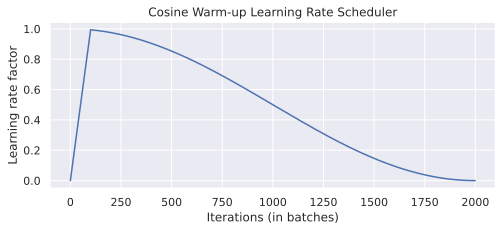

In [17]:
# Needed for initializing the lr scheduler
p = nn.Parameter(torch.empty(4,4))
optimizer = optim.Adam([p], lr=1e-3)
lr_scheduler = CosineWarmupScheduler(optimizer=optimizer, warmup=100, max_iters=2000)

# Plotting
epochs = list(range(2000))
sns.set()
plt.figure(figsize=(8,3))
plt.plot(epochs, [lr_scheduler.get_lr_factor(e) for e in epochs])
plt.ylabel("Learning rate factor")
plt.xlabel("Iterations (in batches)")
plt.title("Cosine Warm-up Learning Rate Scheduler")
plt.show()
sns.reset_orig()

In [149]:
class TransformerPredictor(pl.LightningModule):

    def __init__(self, input_dim, model_dim, num_classes, num_heads, num_layers, lr, warmup, max_iters, dropout=0.0, input_dropout=0.0):
        """
        Inputs:
            input_dim - Hidden dimensionality of the input
            model_dim - Hidden dimensionality to use inside the Transformer
            num_classes - Number of classes to predict per sequence element (output)
            num_heads - Number of heads to use in the Multi-Head Attention blocks
            num_layers - Number of encoder blocks to use.
            lr - Learning rate in the optimizer
            warmup - Number of warmup steps. Usually between 50 and 500
            max_iters - Number of maximum iterations the model is trained for. This is needed for the CosineWarmup scheduler
            dropout - Dropout to apply inside the model
            input_dropout - Dropout to apply on the input features
        """
        super().__init__()
        self.save_hyperparameters()
        self._create_model()

    def _create_model(self):
        # Input dim -> Model dim
        self.input_net = nn.Sequential(
            nn.Dropout(self.hparams.input_dropout),
            nn.Linear(self.hparams.input_dim, self.hparams.model_dim)
        )
        # Positional encoding for sequences
        self.positional_encoding = PositionalEncoding(d_model=self.hparams.model_dim)
        # Transformer
        self.transformer = TransformerEncoder(num_layers=self.hparams.num_layers,
                                              input_dim=self.hparams.model_dim,
                                              dim_feedforward=2*self.hparams.model_dim,
                                              num_heads=self.hparams.num_heads,
                                              dropout=self.hparams.dropout)
        # Output classifier per sequence lement
        self.output_net = nn.Sequential(
            nn.Linear(self.hparams.model_dim, self.hparams.model_dim),
            nn.LayerNorm(self.hparams.model_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(self.hparams.dropout),
            nn.Linear(self.hparams.model_dim, self.hparams.num_classes)
        )

    def forward(self, x, mask=None, add_positional_encoding=True):
        """
        Inputs:
            x - Input features of shape [Batch, SeqLen, input_dim]
            mask - Mask to apply on the attention outputs (optional)
            add_positional_encoding - If True, we add the positional encoding to the input.
                                      Might not be desired for some tasks.
        """
        x = self.input_net(x)
        if add_positional_encoding:
            x = self.positional_encoding(x)
        x = self.transformer(x, mask=mask)
        x = self.output_net(x)
        return x

    @torch.no_grad()
    def get_attention_maps(self, x, mask=None, add_positional_encoding=True):
        """
        Function for extracting the attention matrices of the whole Transformer for a single batch.
        Input arguments same as the forward pass.
        """
        x = self.input_net(x)
        if add_positional_encoding:
            x = self.positional_encoding(x)
        attention_maps = self.transformer.get_attention_maps(x, mask=mask)
        return attention_maps

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.hparams.lr)

        # Apply lr scheduler per step
        lr_scheduler = CosineWarmupScheduler(optimizer,
                                             warmup=self.hparams.warmup,
                                             max_iters=self.hparams.max_iters)
        return [optimizer], [{'scheduler': lr_scheduler, 'interval': 'step'}]

    def _calculate_loss(self, batch, mode="train"):
        # Fetch data and transform categories to one-hot vectors
        inp_data, labels = batch
        inp_data = F.one_hot(inp_data, num_classes=self.hparams.input_dim).float()


        # Perform prediction and calculate loss and accuracy
        preds = self.forward(inp_data, add_positional_encoding=True)
        loss = F.cross_entropy(preds.view(-1, preds.size(-1)), labels.view(-1))
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        # Logging
        self.log(f"{mode}_loss", loss)
        self.log(f"{mode}_acc", acc)
        return loss, acc

    def training_step(self, batch, batch_idx):
        loss, _ = self._calculate_loss(batch, mode="train")
        return loss

    def validation_step(self, batch, batch_idx):
        _ = self._calculate_loss(batch, mode="val")

    def test_step(self, batch, batch_idx):
        _ = self._calculate_loss(batch, mode="test")

## Entrenamiento

In [131]:
BATCH_SIZE = 32
train_dataloader = get_dataloader(batch_size=BATCH_SIZE)

In [97]:
print('en size', input_lang.n_words)
print('spa size', output_lang.n_words)
pairs = filterPairs(pairs)
print('pairs', len(pairs))

en size 11496
spa size 22181
pairs 109709


In [150]:
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import EarlyStopping

def train_reverse(**kwargs):
    # Create a PyTorch Lightning trainer with the generation callback
    logger = CSVLogger(save_dir="logs/", name="transformer-translation")

    early_stopping_callback = EarlyStopping(monitor="train_loss", patience=10, verbose=False, mode="min")

    trainer = pl.Trainer(
          callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"), early_stopping_callback],
          accelerator="auto",
          devices="auto",
          max_epochs=30,
          logger=logger,
    )

    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    model = TransformerPredictor(max_iters=trainer.max_epochs * len(train_dataloader), **kwargs)
    # trainer.fit(model, train_dataloader, val_loader)
    trainer.fit(model, train_dataloader)

    # Test best model on validation and test set
    # val_result = trainer.test(model, val_loader, verbose=False)
    # test_result = trainer.test(model, test_loader, verbose=False)
    # result = {"test_acc": test_result[0]["test_acc"], "val_acc": val_result[0]["test_acc"]}

    model = model.to(device)

    # return model, result
    return model, trainer, None


In [157]:
model, trainer, _ = train_reverse(
    input_dim=input_lang.n_words,
    model_dim=128,
    num_heads=8,
    num_classes=output_lang.n_words,
    num_layers=3,
    dropout=0.3,
    lr=5e-3,
    warmup=50
    )

INFO:pytorch_lightning.utilities.rank_zero:Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type               | Params | Mode 
-----------------------------------------------------------

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


## Evaluación

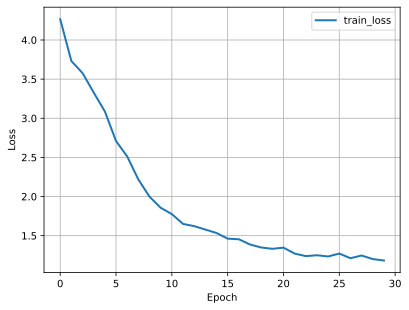

In [158]:
import pandas as pd
import matplotlib.pyplot as plt

# Curvas de aprendizaje del modelo
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

aggreg_metrics = []
agg_col = "epoch"
for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())
    agg[agg_col] = i
    aggreg_metrics.append(agg)

df_metrics = pd.DataFrame(aggreg_metrics)

# Guardar las curvas de aprendizaje para cada métrica
metrics_to_plot = {
    ("train_loss"): "Loss",
}
learning_curves_paths = {}

for (train_metric), ylabel in metrics_to_plot.items():
    if train_metric in df_metrics.columns:
        df_metrics[[train_metric]].plot(grid=True, legend=True, xlabel="Epoch", ylabel=ylabel)

        plt.show()

In [190]:
def evaluate(model, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_tensor = input_tensor.view(-1, input_tensor.shape[0])
        input_tensor = F.one_hot(input_tensor, num_classes=input_lang.n_words).float()
        input_tensor = input_tensor.to(device)

        outputs = model.forward(input_tensor)

        outputs = F.softmax(outputs, dim=-1)

        _, topi = outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])

    return decoded_words


phrases = [
    'he is my brother',
    'she is my sister',
    'sky is blue',
    'there is a thing on the floor',
    'what is your name ?',
    'my brother never showed up in my party',
    'the moon is big',

    'i am learning how to code in c',
    'the weather today is sunny and warm',
    'she loves reading mystery novels on the weekends',
    'we are planning a trip to europe next summer',
    'the cat jumped onto the table and knocked over a glass of water',
    'he works as a software engineer in a big technology company',
    'they went to the grocery store to buy some fresh vegetables',
    'can you help me with my math homework please',
    'the concert last night was amazing',
    'i have never been to new york but i would love to visit someday',
    'it is raining outside',
    'she is a great artist',
    'he loves playing soccer',
    'the dog is barking',
    'i need a cup of coffee',
    'we will meet tomorrow',
    'the sun is setting',
    'they arrived early',
    'the movie was fantastic',
    'i am very tired today',
]

for phrase in phrases:
  print(phrase, '===>', ' '.join(evaluate(model, phrase, input_lang, output_lang)))

he is my brother ===> el es mi hermano SOS
she is my sister ===> ella es mi hermana <EOS>
sky is blue ===> cielo es SOS SOS
there is a thing on the floor ===> hay es un nada esta el suelo SOS
what is your name ? ===> lo es tu nombre ? SOS
my brother never showed up in my party ===> mi hermano nunca a por en mi fiesta SOS
the moon is big ===> el luna es grande SOS
i am learning how to code in c ===> yo SOS aqui como a envio <EOS>
the weather today is sunny and warm ===> el tiempo hoy es ella y calor SOS
she loves reading mystery novels on the weekends ===> ella tom leer el los . el fines SOS
we are planning a trip to europe next summer ===> que ? planea un de a europa proximo verano SOS
the cat jumped onto the table and knocked over a glass of water ===> el gato mary SOS el mesa y a de un vaso de el SOS
he works as a software engineer in a big technology company ===> el trabaja como un la SOS en un gran la compania SOS
they went to the grocery store to buy some fresh vegetables ===> ell

## Comparación con modelo RNN y modelo de atención

In [161]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden  = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None # We return `None` for consistency in the training loop

    def forward_step(self, input, hidden):
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        return output, hidden

In [162]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions

    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

In [163]:
import random

def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

def evaluate_attention(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('')
                break
            decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words, decoder_attn

def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, _ = evaluate_attention(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')


path = "./models/"
loaded_encoder = torch.load(path + "translate_sp_en_encoder.pt", map_location=torch.device(device))
loaded_decoder = torch.load(path + "translate_sp_en_decoder.pt", map_location=torch.device(device))

loaded_encoder_attn = torch.load(path + "translate_sp_en_attn_encoder.pt", map_location=torch.device(device))
loaded_decoder_attn = torch.load(path + "translate_sp_en_attn_decoder.pt", map_location=torch.device(device))

### Comparación de modelos de traducción


In [195]:
# phrase='she is my sister'
# trd_sin_atencion= evaluate_attention(loaded_encoder, loaded_decoder, phrase, input_lang, output_lang)[0]
# trd_con_atencion= evaluate_attention(loaded_encoder_attn, loaded_decoder_attn, phrase, input_lang, output_lang)[0]

# trd_transformer = evaluate(model, phrase, input_lang, output_lang)

# print(f"Traducción sin atención :   {trd_sin_atencion}")
# print(f"Traducción con atención :   {trd_con_atencion}")
# print(f"Traducción con transformer: {trd_transformer}")

def print_comparison(phrase):
  trd_sin_atencion= evaluate_attention(loaded_encoder, loaded_decoder, phrase, input_lang, output_lang)[0]
  trd_con_atencion= evaluate_attention(loaded_encoder_attn, loaded_decoder_attn, phrase, input_lang, output_lang)[0]

  trd_transformer = evaluate(model, phrase, input_lang, output_lang)

  print(f'--- {phrase} ---')
  print(f"Traducción sin atención :   {trd_sin_atencion}")
  print(f"Traducción con atención :   {trd_con_atencion}")
  print(f"Traducción con transformer: {trd_transformer}")

print_comparison('she is my sister')
print_comparison('the movie was fantastic')
print_comparison('we are planning a trip to europe next summer')

--- she is my sister ---
Traducción sin atención :   ['piensalo', 'cumplira', 'a', 'escapaba', 'enamorado', 'maletas', 'izo', 'ser', 'actualizando', '']
Traducción con atención :   ['ella', 'minga', 'abierta', 'recibe', 'encontraba', 'aprenda', 'muriendo', '']
Traducción con transformer: ['ella', 'es', 'mi', 'hermano', 'SOS']
--- the movie was fantastic ---
Traducción sin atención :   ['escapaba', 'esas', 'puede', 'lamento', 'gentiles', '']
Traducción con atención :   ['serio', 'aprueba', 'escapaba', 'tomo', 'cierra', 'tesoro', '']
Traducción con transformer: ['el', 'pelicula', 'era', 'fantastico', 'SOS']
--- we are planning a trip to europe next summer ---
Traducción sin atención :   ['prueba', 'a', 'ganaste', 'silencio', 'minga', 'serio', 'aficionado', 'ser', 'preguntale', '']
Traducción con atención :   ['esconder', 'quieras', 'otra', 'saludo', 'consumir', 'por', '']
Traducción con transformer: ['nosotros', 'son', '?', 'un', 'viaje', 'ella', 'europa', 'viene', 'verano', 'SOS']
